---
title: EOPF Zarr Data Access with openEO and STAC 
subtitle: Learn how to use the EOPF Zarr data through STAC and openEO
authors:
  - name: Peter Zellner
    orcid: 0000-0002-3394-9664
    github: przell
    affiliations:
      - id: DLR
        institution: German Aerospace Center
        ror: 04bwf3e34
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-09-25
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["openeo", "stac", "sentinel-2"]
releaseDate: 2025-08-29
datePublished: 2025-09-24
dateModified: 2025-08-29
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Connect to openEO](#Connect-to-openEO)
- [Load a virtual data cube](#Load-a-virtual-data-cube)
- [Create a processing workflow](#Create-a-processing-workflow)
- [Compare to other sources](#Compare-to-other-sources)

(Introduction)=
## Introduction

This is a practical introduction to showcasing the **interoperability** of EOPF Zarr with openEO by accessing and processing EOPF Zarr products via STAC and the openEO API. OpenEO is a unified interface that makes earth observation workflows more standardised, portable, and **reproducible**. 

:::{hint} Overview
Scope
- Introdcution on how to use openEO with the new EOPF Zarr format
- Exploiting interoperability between the new EOPF Zarr format, STAC and the openEO API
- Creating a portable and reproducible workflow

Content
- Accessing EOPF Zarr data with openEO
- Creating customised virtual data cubes
- Running simple processing workflows
- Comparing different sources of Sentinel data reusing openEO workflows

:::

(Setup)=
## Setup
Start importing the necessary libraries

```
pip install openeo-processes-dask[implementations]
pip install openeo-pg-parser-networkx
```

In [1]:
from openeo.local import LocalConnection

Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`


In [2]:
# import openeo # Un-Comment once pull-requests are merged.
import rioxarray as rxr
import dask
from xcube_eopf.utils import reproject_bbox

(Connect-to-openEO)=
## Connect to openEO
Connect to an openEO backend. 

In [3]:
connection = LocalConnection("./")

In [4]:
# Un-Comment once pull-requests are merged and deployed on EODC backend!
# connection_url = "https://openeo.eodc.eu/" # this is throwing an 504 failed to parse error message in the first .download
# connection = openeo.connect(connection_url).authenticate_oidc()

More information on [openEO](https://openeo.org/) and how to use openEO with some [tutorials](https://openeo.org/documentation/0.4/getting-started.html).

(Load-a-virtual-data-cube)=
## Load a virtual data cube
First, we'll define the extents in time and space we are interested in

In [5]:
bbox = [
    9.669372670305636,
    53.64026948239441,
    9.701345402674315,
    53.66341039786631,
]  # ~250x250 px Northern Germany, Moorrege.
time_range = ["2025-05-01", "2025-06-01"]

Define the URL to the STAC resource you want to query. And the band names - they are often specific to the STAC Catalogs used.

In [6]:
stac_url = "https://stac.core.eopf.eodc.eu/collections/sentinel-2-l2a"
bands = ["b02", "b08"]  # bandnames are specific to the STAC Catalogs

Reproject the bbox to the native crs of the STAC items, so that `xcube-eopf`(which is used under the hood in `load_stac()`) does not trigger reprojection internally. See detailed behavior [here](https://eopf-sample-service.github.io/xcube-eopf/guide/#sentinel-2).

In [7]:
crs_reprj = "EPSG:32632"
bbox_reprj = reproject_bbox(bbox, "EPSG:4326", crs_reprj)

spatial_extent_reprj = {
    "west": bbox_reprj[0],
    "south": bbox_reprj[1],
    "east": bbox_reprj[2],
    "north": bbox_reprj[3],
    "crs": crs_reprj,
}

Create a **virtual data cube** via the funtion `load_stac()` according to the chosen extents. This also includes the search on the STAC API. Data is not loaded into the working environment here.

In [8]:
cube = connection.load_stac(
    url=stac_url,
    spatial_extent=spatial_extent_reprj,
    temporal_extent=time_range,
    bands=bands,
)

Inspect the `load_stac()` process visually.

In [9]:
cube

(Create-a-processing-workflow)=
## Create a processing workflow
Apply processing. We're calculating the NDVI. And getting a monthly mean.

In [10]:
red = cube.band(bands[0])
nir = cube.band(bands[1])
cube_ndvi = (nir - red) / (nir + red)
cube_mnth = cube_ndvi.reduce_dimension(dimension="time", reducer="mean")

Inspect the worflow visually.

In [11]:
cube_mnth

Finalize the workflow via `.execute()` for the locally executed openEO version or `.download()` when connected to an openeo backend. *The data is not loaded into the working environment now!*

*Note: Currently we are using the local processing version of openEO. It is not sending any requests to an actual backend. It is converting the openEO process graph to an executable Python code. It's interacting only with the STAC API and the data buckets.*

*Note: `.execute()` also redoes the STAC API search currently.*

In [12]:
res = cube_mnth.execute()
dask.is_dask_collection(res)  # check wether data is still lazy.

True

But we can inspect the dimensionality of the virtual cube.

In [13]:
res

<xarray.DataArray (y: 261, x: 215)> Size: 449kB
dask.array<mean_agg-aggregate, shape=(261, 215), dtype=float64, chunksize=(261, 215), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
Attributes: (5)

Process and load the data into the working environment.

In [14]:
res = res.compute()
dask.is_dask_collection(
    res
)  # now the data is loaded, it's not a dask collection anymore.

False

In [15]:
res  # the actual values are accessible in the working environment.

<xarray.DataArray (y: 261, x: 215)> Size: 449kB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.2873431 , 0.26428244, ..., 0.27416113, 0.2887649 ,
        0.27177581],
       [       nan, 0.2425711 , 0.20880796, ..., 0.28848023, 0.30780635,
        0.27795899],
       ...,
       [       nan, 0.32267183, 0.3338486 , ..., 0.37769097, 0.38114659,
        0.38854037],
       [       nan, 0.31538128, 0.31447261, ..., 0.37491768, 0.3760886 ,
        0.38004317],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    spatial_ref  int64 8B 0
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
Attributes: (5)

Plot the map.

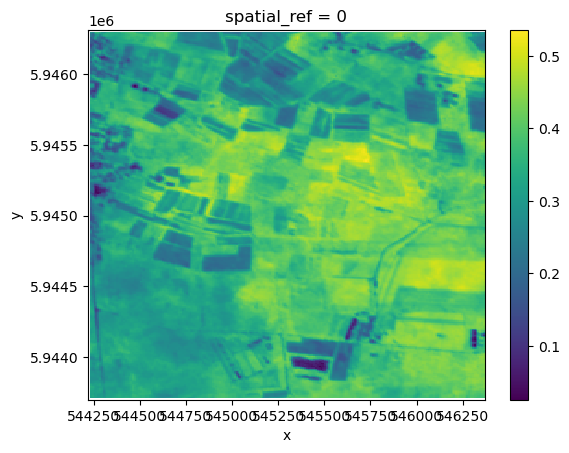

In [16]:
res.plot()

(Compare-to-other-sources)=
## Compare to other sources
We'll reuse the process graph we have created and only change the URL to the STAC API to use other sources of input. This is a good example of portability and reproducibility.

In [17]:
def load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim):
    cube = connection.load_stac(
        url=stac_url,
        spatial_extent={
            "west": bbox[0],
            "south": bbox[1],
            "east": bbox[2],
            "north": bbox[3],
        },
        temporal_extent=time_range,
        bands=bands,
    )

    red = cube.band(bands[0])
    nir = cube.band(bands[1])
    cube_ndvi = (nir - red) / (nir + red)
    cube_mnth = cube_ndvi.reduce_dimension(dimension=time_dim, reducer="mean")
    return cube_mnth

### MS Planetary Computer
[MS Planetary Computer](https://planetarycomputer.microsoft.com/catalog) is a stable source of satellite data made available via a STAC API. The Sentinel-2 L2A data has been transformed to **Cloud Optimized GeoTiffs (COG)** in this collection.

In [18]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a"  # cog
bands = ["B02", "B08"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim="time")

Finalize the reused workflow via `.execute()`. *The data is not loaded into the working environment yet.*

In [19]:
res_mspc = cube_mnth.execute()
dask.is_dask_collection(res_mspc)

True

But we can inspect the dimensionality of the virtual cube already. The spatial extents are slightly different than what we have received from the EOPF STAC API. This is probably due to the internal reprojection of the bbox. *The data is not loaded into the working environment yet.*

In [20]:
res_mspc

<xarray.DataArray (y: 259, x: 214)> Size: 222kB
dask.array<mean_agg-aggregate, shape=(259, 214), dtype=float32, chunksize=(259, 214), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
    spatial_ref  int32 4B 32632
Attributes: (1)

Now we are processing and loading the data into the working enviornment.

In [21]:
res_mspc = res_mspc.compute()
res_mspc

<xarray.DataArray (y: 259, x: 214)> Size: 222kB
array([[0.21101841, 0.1990689 , 0.26482955, ..., 0.22330226, 0.23107414,
        0.22176808],
       [0.17871606, 0.14319965, 0.20382324, ..., 0.24455512, 0.25198448,
        0.21950312],
       [0.18152685, 0.14044613, 0.17457631, ..., 0.22218844, 0.22560354,
        0.21909603],
       ...,
       [0.23230581, 0.23385616, 0.22969323, ..., 0.2867954 , 0.2883512 ,
        0.29489034],
       [0.238755  , 0.24818583, 0.24143131, ..., 0.27675226, 0.2899914 ,
        0.29723066],
       [0.23988518, 0.24029757, 0.24076228, ..., 0.27344242, 0.28382626,
        0.28549477]], dtype=float32)
Coordinates:
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
    spatial_ref  int32 4B 32632
Attributes: (1)

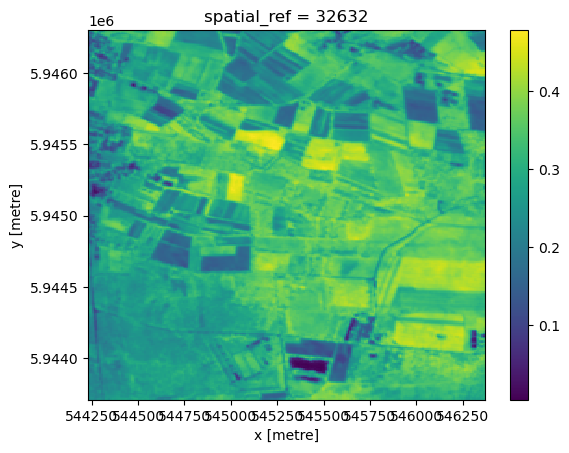

In [22]:
res_mspc.plot()

Let's check the differences of the two results. *Note: Differences occur mainly due to the older processing version (2.11) of Sentinel-2 used on MS Planetary Computer.*

In [23]:
diff = res - res_mspc
diff.to_series().describe()

count    55426.000000
mean         0.055157
std          0.025907
min         -0.036408
25%          0.037149
50%          0.054587
75%          0.071017
max          0.172499
dtype: float64

### CDSE - via openEO

Connect to openEO on CDSE. This also authorizes us to request data from the CDSE STAC API. 

In [24]:
import openeo

In [25]:
connection_url = "openeo.dataspace.copernicus.eu"
connection = openeo.connect(connection_url).authenticate_oidc()

Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=IYDN-IWHC 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.


In [26]:
stac_url = (
    "https://stac.dataspace.copernicus.eu/v1/collections/sentinel-2-l2a/"  # safe format
)
bands = ["B02", "B08"]
cube_mnth = load_ndvi_mean(stac_url, bbox, time_range, bands, time_dim="t")

Since we're connected to the CDSE openEO backend we need to download the result (only JSON can be received via `.exectue()`). *This triggers the processing on the openEO backend as a synchronous call. To register a batch job on the backend and execute it asynchronously use `.execute_batch()`* 

In [27]:
res_cdse_backend = cube_mnth.download("res_cdse_backend.tif")

And load it into the working environment.

In [28]:
res_cdse_backend = rxr.open_rasterio("res_cdse_backend.tif")

Here we get the same extents as from EOPF. By loading via `rioxarray` the ndvi values are encoded into a band dimension. 

In [29]:
res_cdse_backend

<xarray.DataArray (band: 1, y: 261, x: 215)> Size: 224kB
[56115 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB 5.442e+05 5.442e+05 ... 5.464e+05 5.464e+05
  * y            (y) float64 2kB 5.946e+06 5.946e+06 ... 5.944e+06 5.944e+06
    spatial_ref  int64 8B 0
Attributes: (5)

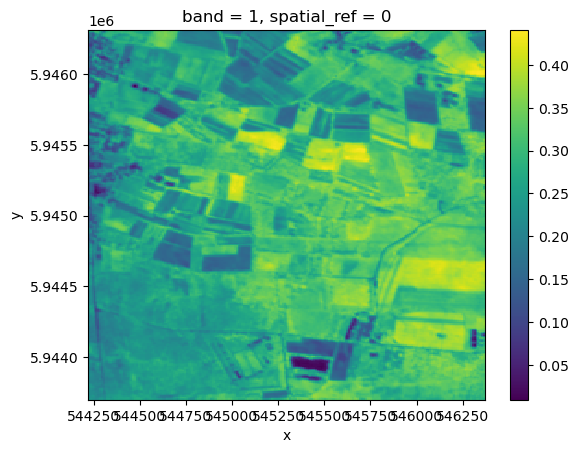

In [30]:
res_cdse_backend.plot()

Let's check the differences. Very marginal, likely due to different software used in the different openEO implementations used.

In [31]:
diff2 = res - res_cdse_backend
diff2.to_series().describe()

count    55426.000000
mean         0.078158
std          0.023538
min         -0.006268
25%          0.062287
50%          0.077005
75%          0.092643
max          0.174986
dtype: float64

## Takeaway
This tutorial has shown how to:
- Access EOPF Zarr Data via STAC and openEO
- Apply reusable processing workflows via openEO
- Compared the EOPF Zarr Data to other available Sentinel-2 sources

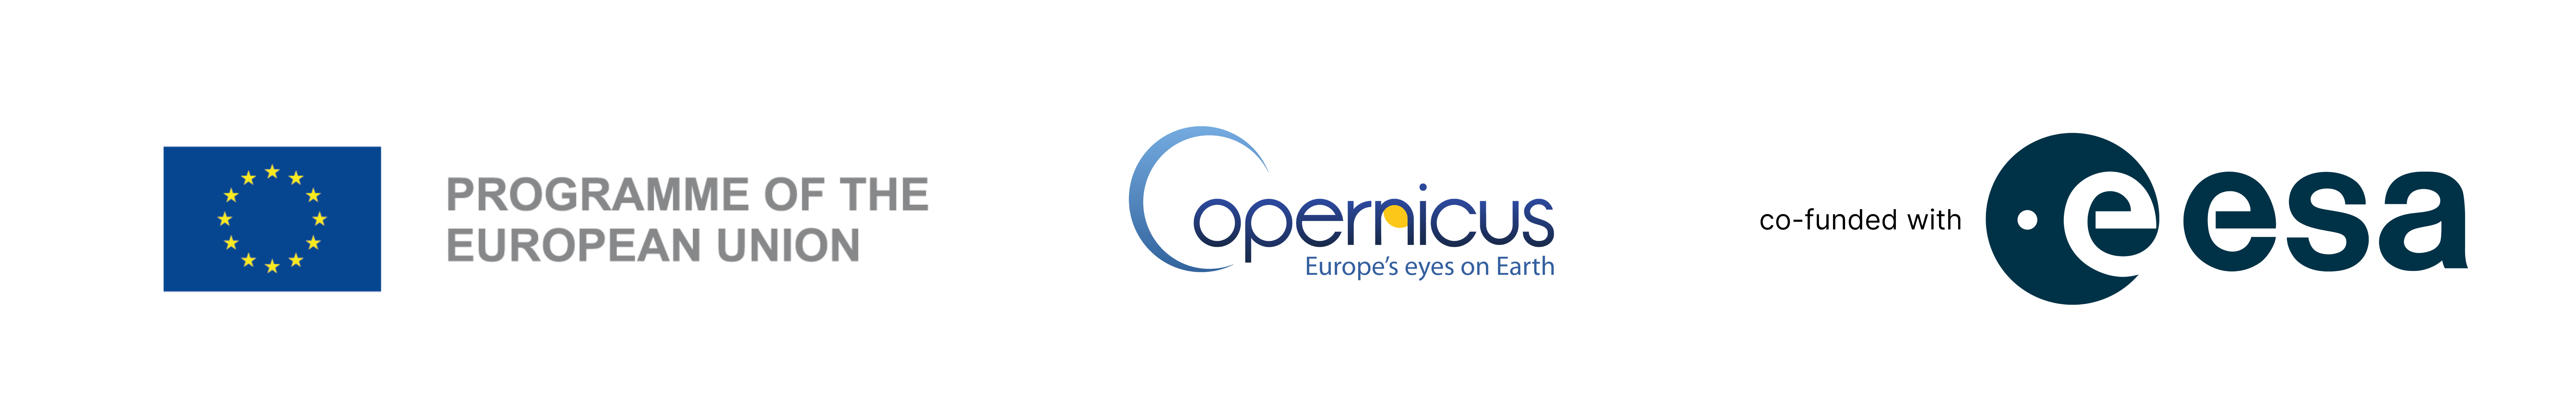